<a href="https://colab.research.google.com/github/BT21PrKu/Clustering-Using-Pycaret/blob/main/ClusteringAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret &> /dev/null
print ("Pycaret installed sucessfully!!")

Pycaret installed sucessfully!!


In [ ]:
from pycaret.utils import version
version()

'3.2.0'

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
df = fetch_ucirepo(id=292)



In [ ]:
import pandas as pd

# Dataset URL
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"

# Load the dataset
df = pd.read_csv(dataset_url)

# Display the first few rows
print(df.head())


   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [ ]:
df.shape

(440, 8)

In [ ]:
import numpy as np
from pycaret.clustering import *
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [ ]:
def prog(preprocess_dict, cluster_algorithm, cluster_sizes, df):
    results = []
    for preprocess in preprocess_dict:
        # Setup PyCaret with specific preprocessing options
        clf = setup(data=df, normalize=preprocess['normalize'],
                    transformation=preprocess['transform'], pca=preprocess['pca'],normalize_method = 'zscore',
                    transformation_method = 'yeo-johnson',
                    pca_method = 'linear',
                    verbose=False)

        for size in cluster_sizes:
            # Create model based on the algorithm
            if cluster_algorithm == 'kmeans':
                model = create_model('kmeans', num_clusters=size)
            elif cluster_algorithm == 'hierarchical':
                model = create_model('hclust', num_clusters=size)
            elif cluster_algorithm == 'mean_shift':
                # Mean Shift does not use num_clusters
                model = create_model('meanshift')

            # Assign model to data
            df_assigned = assign_model(model)
            labels = df_assigned['Cluster']

            # Calculating metrics
            if 'mean_shift' not in cluster_algorithm:  # For mean_shift, cluster size is not predefined
                silhouette = silhouette_score(df_assigned.drop(columns=['Cluster']), labels)
                calinski_harabasz = calinski_harabasz_score(df_assigned.drop(columns=['Cluster']), labels)
                davies_bouldin = davies_bouldin_score(df_assigned.drop(columns=['Cluster']), labels)

                results.append({'Preprocess': preprocess['name'], 'Clusters': size,
                                'Silhouette': silhouette, 'Calinski-Harabasz': calinski_harabasz,
                                'Davies-Bouldin': davies_bouldin})
            else:
                # For mean_shift, since cluster size is not predefined, we adjust the reporting accordingly
                unique_clusters = len(pd.unique(labels))
                results.append({'Preprocess': preprocess['name'], 'Clusters': unique_clusters,
                                'Silhouette': silhouette, 'Calinski-Harabasz': calinski_harabasz,
                                'Davies-Bouldin': davies_bouldin})

    return pd.DataFrame(results)

In [ ]:
import pandas as pd
from pycaret.clustering import *
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Preprocessing configurations
preprocess_configs = [
    {'name': 'No Preprocessing', 'normalize': False, 'transform': False, 'pca': False},
    {'name': 'Normalize', 'normalize': True, 'transform': False, 'pca': False},
    {'name': 'Transform', 'normalize': False, 'transform': True, 'pca': False},
    {'name': 'PCA', 'normalize': False, 'transform': False, 'pca': True},
    {'name': 'Transform + Normalize', 'normalize': True, 'transform': True, 'pca': False},
    {'name': 'Transform + Normalize + PCA', 'normalize': True, 'transform': True, 'pca': True},
]

# Initialize results dictionaries
results_kmeans = []
results_hierarchical = []
results_mean_shift = []

for preprocess in preprocess_configs:
    # Setup environment in PyCaret
    s = setup(data=df, normalize=preprocess['normalize'],
              transformation=preprocess['transform'], pca=preprocess['pca'],normalize_method = 'zscore',
              transformation_method = 'yeo-johnson',
              pca_method = 'linear',
              verbose=False)

    # KMeans for specific cluster sizes
    for cluster_size in [3, 4, 5]:
        model = create_model('kmeans', num_clusters=cluster_size)
        labels = assign_model(model)['Cluster']
        # Calculate metrics
        silhouette = silhouette_score(df, labels)
        calinski_harabasz = calinski_harabasz_score(df, labels)
        davies_bouldin = davies_bouldin_score(df, labels)
        results_kmeans.append({
            'Preprocess': preprocess['name'],
            'Clusters': cluster_size,
            'Silhouette': silhouette,
            'Calinski-Harabasz': calinski_harabasz,
            'Davies-Bouldin': davies_bouldin
        })

    # Hierarchical for specific cluster sizes
    for cluster_size in [3, 4, 5]:
        model = create_model('hclust', num_clusters=cluster_size)
        labels = assign_model(model)['Cluster']
        # Calculate metrics
        silhouette = silhouette_score(df, labels)
        calinski_harabasz = calinski_harabasz_score(df, labels)
        davies_bouldin = davies_bouldin_score(df, labels)
        results_hierarchical.append({
            'Preprocess': preprocess['name'],
            'Clusters': cluster_size,
            'Silhouette': silhouette,
            'Calinski-Harabasz': calinski_harabasz,
            'Davies-Bouldin': davies_bouldin
        })

    # Mean Shift (no predefined cluster size)
    model = create_model('meanshift')
    labels = assign_model(model)['Cluster']
    unique_clusters = len(pd.unique(labels))
    # Calculate metrics
    silhouette = silhouette_score(df, labels)
    calinski_harabasz = calinski_harabasz_score(df, labels)
    davies_bouldin = davies_bouldin_score(df, labels)
    results_mean_shift.append({
        'Preprocess': preprocess['name'],
        'Clusters': unique_clusters,
        'Silhouette': silhouette,
        'Calinski-Harabasz': calinski_harabasz,
        'Davies-Bouldin': davies_bouldin
    })

df_kmeans = pd.DataFrame(results_kmeans)
df_hierarchical = pd.DataFrame(results_hierarchical)
df_mean_shift = pd.DataFrame(results_mean_shift)

# Save to CSV
df_kmeans.to_csv('KMeansResults.csv', index=False)
df_hierarchical.to_csv('HierarchicalResults.csv', index=False)
df_mean_shift.to_csv('MeanShiftResults.csv', index=False)


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4770,210.1456,0.8905,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3866,207.8197,0.9543,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3833,215.0578,0.9020,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3750,183.3597,0.9783,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3483,185.2559,0.9701,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3522,196.9540,0.9106,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3644,54.7541,0.5765,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3598,139.6169,1.2491,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3482,130.9179,1.2359,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3529,137.9523,1.1481,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3600,126.2475,1.1551,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3623,120.7561,0.8255,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3178,123.5061,0.8960,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4054,30.8599,0.4229,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8554,13039.7633,0.3389,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5181,15162.6315,0.6203,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4626,14223.7871,0.6958,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8554,13039.7633,0.3389,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5109,14291.9587,0.6054,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4530,14101.6445,0.7125,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.9076,14114.2429,0.1625,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4784,210.1526,0.8895,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3985,207.8195,0.9019,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3833,215.0578,0.9020,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3750,183.3597,0.9783,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3483,185.2559,0.9701,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3522,196.9540,0.9106,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3644,54.7541,0.5765,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2228,153.5484,1.6406,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2476,136.3494,1.4215,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2186,121.1400,1.5879,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2288,138.5574,1.5189,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2425,127.8460,1.4576,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2073,112.2108,1.4930,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3461,17.4754,1.0571,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2228,153.5484,1.6406,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2473,136.3422,1.4213,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2184,121.2396,1.5850,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2288,138.5574,1.5189,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2425,127.8460,1.4576,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2073,112.2108,1.4930,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3461,17.4754,1.0571,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Pivot table for KMeans Silhouette scores
kmean_silhouette_pivot = df_kmeans.pivot_table(values='Silhouette',
                                                   index='Preprocess',
                                                   columns='Clusters',
                                                   aggfunc='mean')

print("KMeans Silhouette Scores:")
print(kmean_silhouette_pivot)


KMeans Silhouette Scores:
Clusters                            3         4         5
Preprocess                                               
No Preprocessing             0.477018  0.386631  0.383296
Normalize                    0.211305  0.040512  0.029934
PCA                          0.478351  0.398506  0.383296
Transform                   -0.043002  0.016062 -0.006168
Transform + Normalize        0.183556  0.003292 -0.040405
Transform + Normalize + PCA  0.183556  0.003796 -0.036100


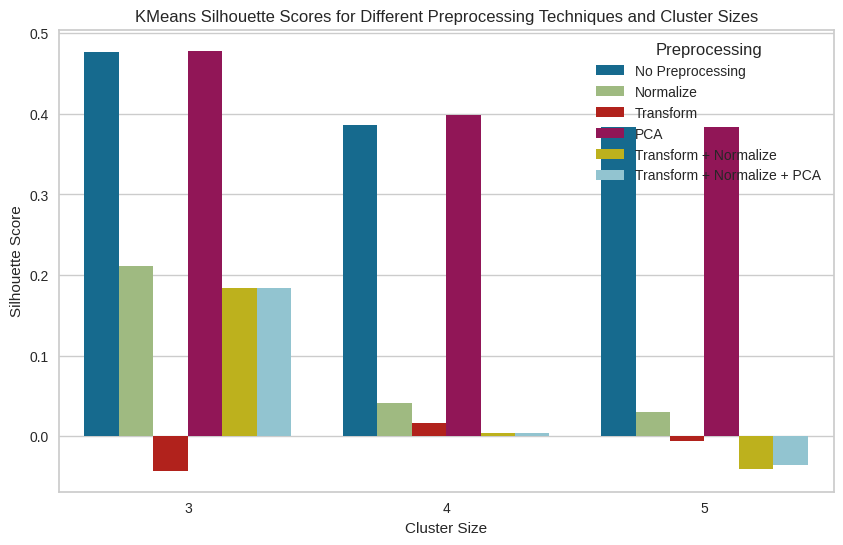

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot for KMeans Silhouette scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Clusters', y='Silhouette', hue='Preprocess', data=df_kmeans)
plt.title('KMeans Silhouette Scores for Different Preprocessing Techniques and Cluster Sizes')
plt.xlabel('Cluster Size')
plt.ylabel('Silhouette Score')
plt.legend(title='Preprocessing')
plt.show()


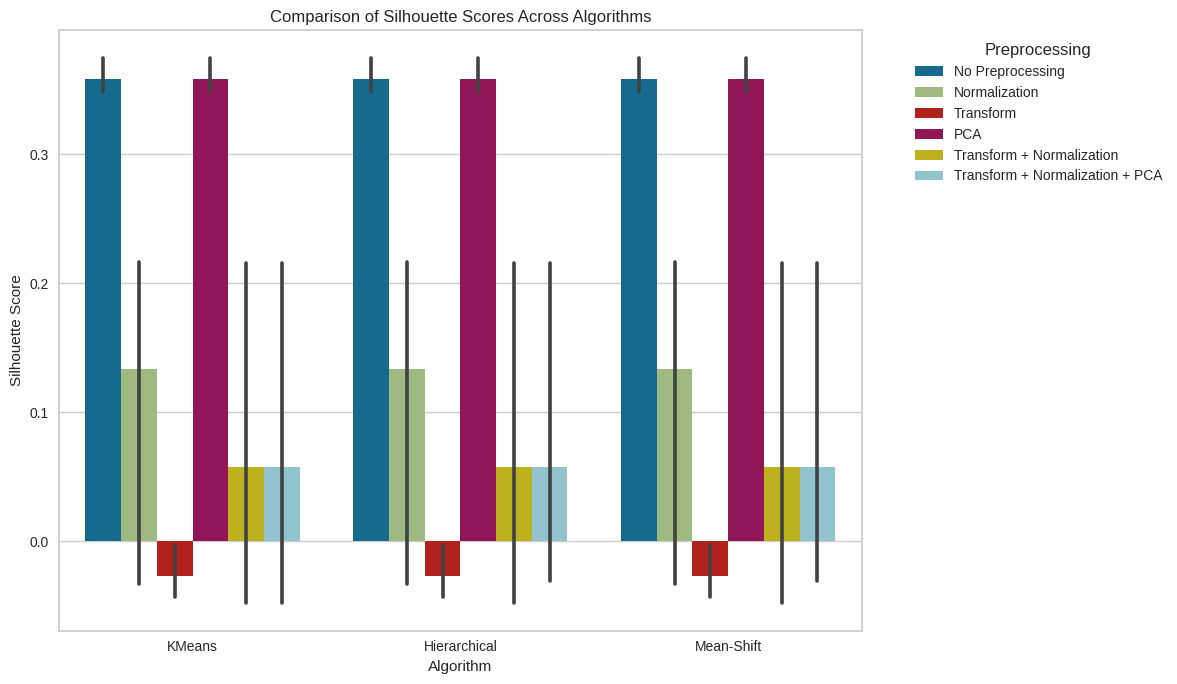

In [ ]:
# Add an 'Algorithm' column to each DataFrame
kmean_results['Algorithm'] = 'KMeans'
hierarchical_results['Algorithm'] = 'Hierarchical'
mean_shift_results['Algorithm'] = 'Mean-Shift'

# Concatenate the results
all_results = pd.concat([kmean_results, hierarchical_results, mean_shift_results])

# Plot comparison
plt.figure(figsize=(12, 7))
sns.barplot(x='Algorithm', y='Silhouette', hue='Preprocess', data=all_results)
plt.title('Comparison of Silhouette Scores Across Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Silhouette Score')
plt.legend(title='Preprocessing', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


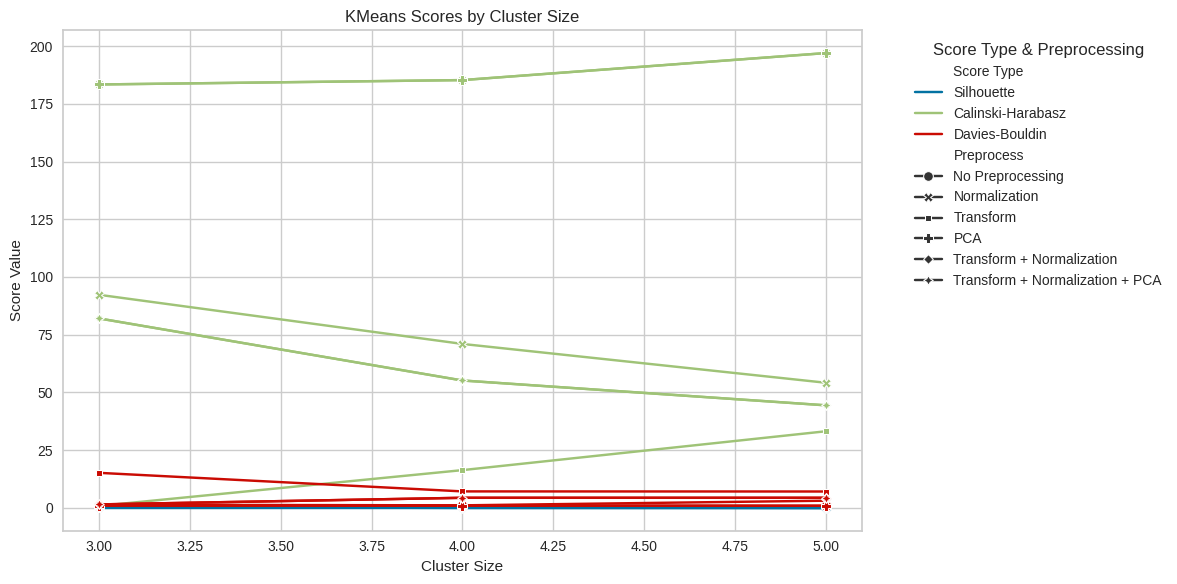

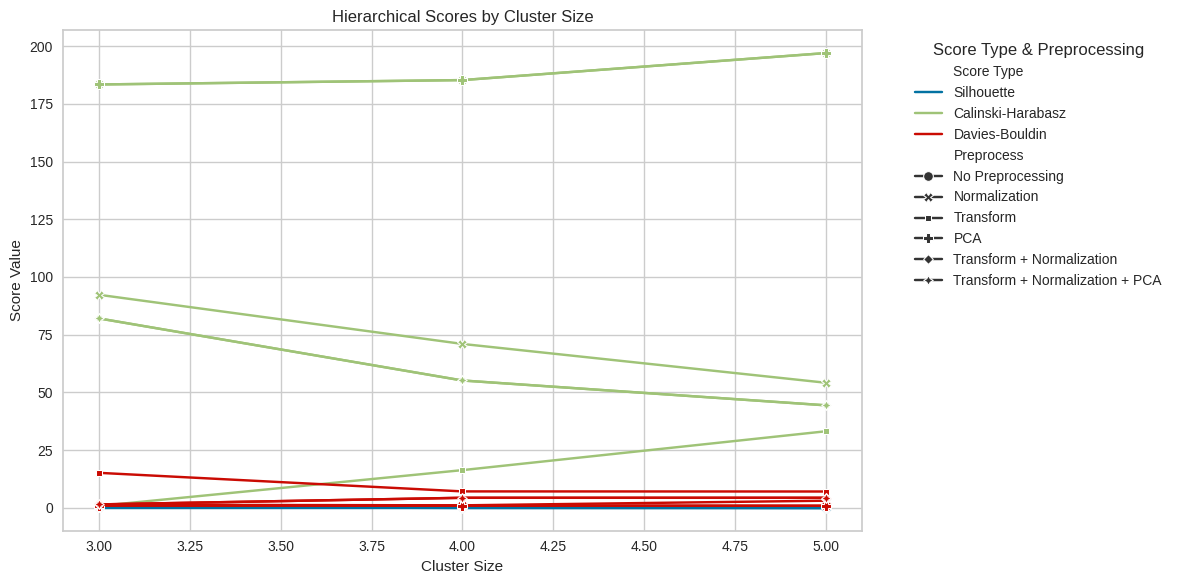

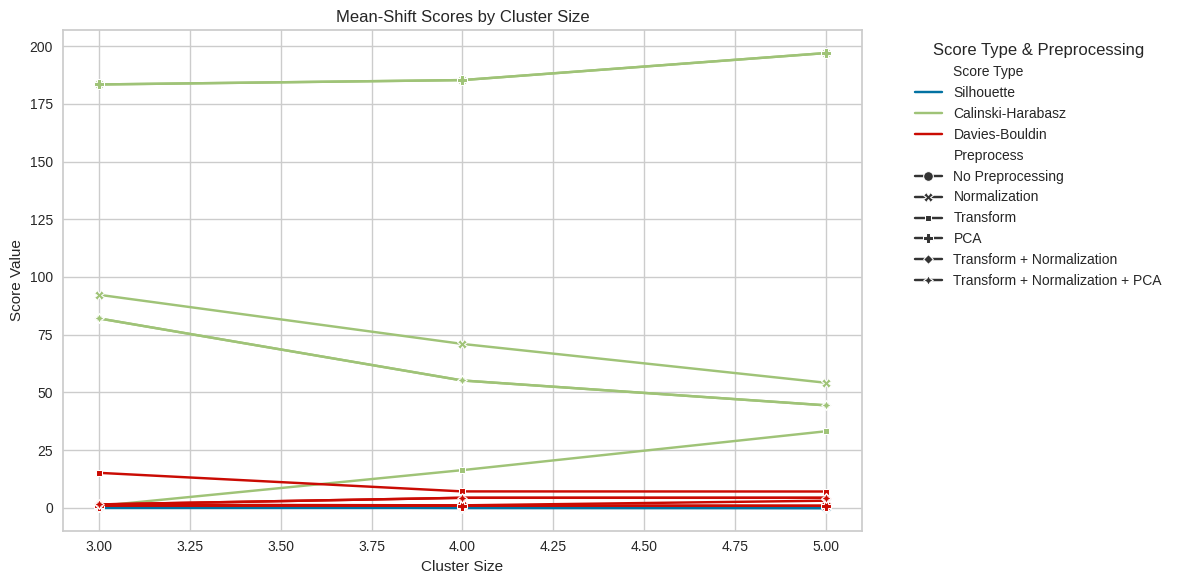

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_scores(results, algorithm_name):
    # Melt the dataframe to make it suitable for seaborn plotting
    melted_results = pd.melt(results, id_vars=['Clusters', 'Preprocess'],
                             value_vars=['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'],
                             var_name='Score Type', value_name='Score')

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=melted_results, x='Clusters', y='Score', hue='Score Type', style='Preprocess', markers=True, dashes=False)
    plt.title(f'{algorithm_name} Scores by Cluster Size')
    plt.xlabel('Cluster Size')
    plt.ylabel('Score Value')
    plt.legend(title='Score Type & Preprocessing', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot for each algorithm
plot_scores(kmean_results, 'KMeans')
plot_scores(hierarchical_results, 'Hierarchical')
plot_scores(mean_shift_results, 'Mean-Shift')
# If mean_shift_results are structured to include 'Cluster Size', you can plot them as well


ValueError: cannot convert float NaN to integer

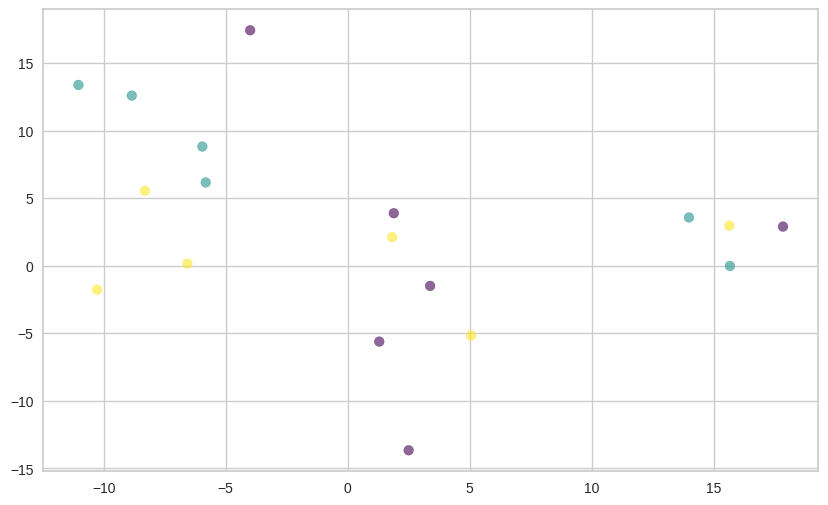

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the original dataset
# Ensure that df is your original DataFrame used for clustering

# Load the clustering results
cluster_results = pd.read_csv('KMeansResults.csv')

# Assuming 'cluster_labels' column in your results CSV contains the cluster labels
# And your original DataFrame (df) and cluster_results are aligned row-wise
df['Cluster'] = cluster_results['Clusters']

# Select features for t-SNE, excluding the cluster labels
# Filling NaNs with the mean of each column
# Ensure this makes sense for your dataset; otherwise, consider using median or a placeholder value
features_for_tsne = df.drop('Cluster', axis=1)
# Fill NaNs with the mode of each column
for column in features_for_tsne.columns:
    mode_value = features_for_tsne[column].mode()[0]  # Get the mode of each column
    features_for_tsne[column].fillna(mode_value, inplace=True)

# Now that NaNs are filled, you can proceed with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features_for_tsne)

# Assuming 'Cluster' is in df and corresponds to the rows in features_for_tsne after filling NaNs
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.6)

# Create a legend
plt.legend(*scatter.legend_elements(), title="Clusters")

plt.title('t-SNE Clustering Visualization')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()
